# Computer Vision - Image Stitching
#### Gerry Guinardi - 2440015556
#### Ho Michael Gunawan - 2440037771
#### Vito Pramudita Minardi - 2440060231
---

### Using the images of Taj Mahal as it is shown below, create one panoramic image using image stitching technique. Clearly write the algorithm you followed, implement your respective algorithm in python notebook and show the final combined image. You may need to install imutils python library
![image](example.jpg)


In [1]:
# import packages
from imutils import paths
import numpy as np
import argparse
import imutils
import cv2
import os
import matplotlib.pyplot as plt

In [2]:
# image path
imagePath = './images'
images = []

# retrieve and read image to images
for filename in os.listdir(imagePath):
    image = cv2.imread(imagePath + '/' + filename)
    images.append(image)

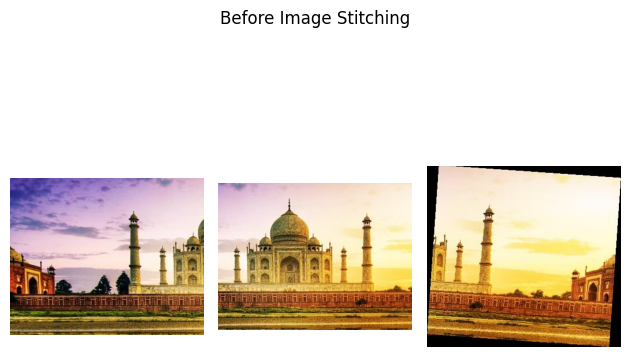

In [3]:
# show images before stitching
fig = plt.figure()
for index, image in enumerate(images):
    ax = fig.add_subplot(1, len(images), index+1)
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax.axis('off')

fig.suptitle("Before Image Stitching")
plt.tight_layout()
plt.show()

(-0.5, 854.5, 346.5, -0.5)

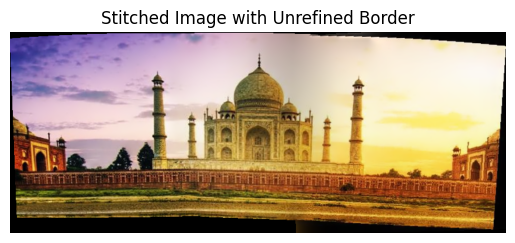

In [4]:
stitcher = cv2.Stitcher_create()
(status, stitched) = stitcher.stitch(images)

plt.title("Stitched Image with Unrefined Border")
plt.imshow(cv2.cvtColor(stitched, cv2.COLOR_BGR2RGB))
plt.axis("off")

In [5]:
def cropImage(stitched_images):
    # This creates a 10 pixel border around the images
    stitched_images = cv2.copyMakeBorder(
        stitched_images, 
        10, 
        10, 
        10, 
        10, 
        cv2.BORDER_CONSTANT,
        (0, 0, 0)
        )

    # convert the stitched image to grayscale and threshold it such that all pixels greater than zero are set to 255 (foreground) while all others remain 0 (background)
    gray = cv2.cvtColor(stitched_images, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

    # find all external contours in the threshold image then find the largest contour which will be the contour/outline of the stitched image
    contour = cv2.findContours(
        thresh.copy(), 
        cv2.RETR_EXTERNAL, 
        cv2.CHAIN_APPROX_SIMPLE
        )
    contour = imutils.grab_contours(contour)
    c = max(contour, key=cv2.contourArea)

    # CREATE MASK
    # allocate memory for the mask which will contain the rectangular bounding box of the stitched image region
    mask = np.zeros(thresh.shape, dtype='uint8')
    (x, y, w, h) = cv2.boundingRect(c)
    cv2.rectangle(mask, (x, y), (x + w, y + h), 255, -1)

    # EXTRACT PANORAMIC IMAGE USING ERODE
    # create two copies of the mask: one to serve as our actual minimum rectangular region and another to serve as a counter for how many pixels need to be removed to form the minimum rectangular region
    minRect = mask.copy()
    sub = mask.copy()

    # keep looping until there are no non-zero pixels left in the subtracted image
    while cv2.countNonZero(sub) > 0:
        # erode the minimum rectangular mask and then subtract the thresholded image from the minimum rectangular mask so we can count if there are any non-zero pixels left
        minRect = cv2.erode(minRect, None)
        sub = cv2.subtract(minRect, thresh)

    # find contours in the minimum rectangular mask and then extract the bounding box (x, y)-coordinates
    contour = cv2.findContours(
        minRect.copy(), 
        cv2.RETR_EXTERNAL, 
        cv2.CHAIN_APPROX_SIMPLE
        )

    contour = imutils.grab_contours(contour)
    c = max(
        contour, 
        key=cv2.contourArea
        )

    (x, y, w, h) = cv2.boundingRect(c)

    # use the bounding box coordinates to extract the our final stitched image
    stitched_images = stitched_images[y:y + h, x:x + w]
    return stitched_images

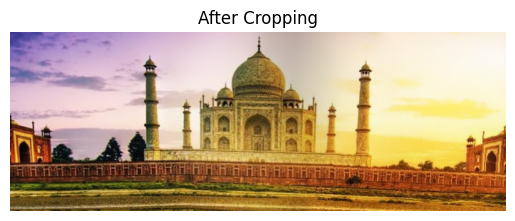

In [6]:
# display the output of the stitched image
croped_image = cropImage(stitched)
plt.title("After Cropping")
plt.imshow(cv2.cvtColor(croped_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()